In [11]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt



In [23]:
n_samples = 2000

x,y = make_circles(n_samples,noise=0.04,random_state=42)

In [24]:
circles = pd.DataFrame({'x1':x[:,0],
                        'x2':x[:,-1],'label':y})

circles.head()

,x1,x2,label
0,0.458152,-0.569978,1
1,-0.621638,0.811655,0
2,-0.400425,0.712738,1
3,0.830153,-0.613403,0
4,-0.154229,0.756351,1


In [25]:
circles.label.value_counts()

1    1000
0    1000
Name: label, dtype: int64

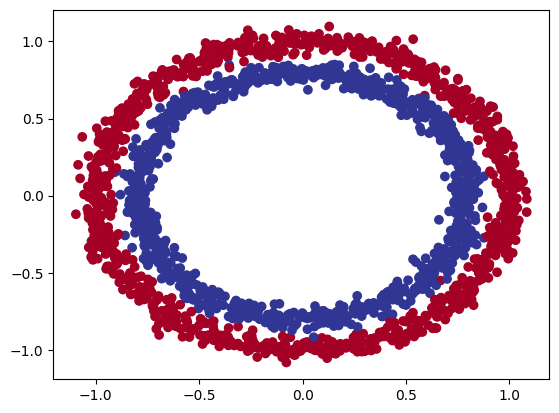

In [26]:
# Visualize with a plot
plt.scatter(x=x[:, 0], 
            y=x[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [27]:
x.shape,y.shape

((2000, 2), (2000,))

In [29]:
import torch
from sklearn.model_selection import train_test_split

In [30]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5],y[:5]

(tensor([[ 0.4582, -0.5700],
         [-0.6216,  0.8117],
         [-0.4004,  0.7127],
         [ 0.8302, -0.6134],
         [-0.1542,  0.7564]]),
 tensor([1., 0., 1., 0., 1.]))

In [31]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)


len(x_train),len(x_test),len(y_train),len(y_test)

(1600, 400, 1600, 400)

In [32]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

## model 0

In [33]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)
        
    def forward(self,x):
        return self.layer_2(self.layer_1(x))
    
    
model_0 = CircleModelV0().to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [44]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)
# calc accuracy

def accuracy(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum()
    
    return (correct/len(y_pred))*100

In [53]:
# training loop

torch.manual_seed(42)

epochs = 250

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_0(x_train).squeeze() # y_logits - numerical value, squeeze to remove extra 1 dimension
    y_pred = torch.round(torch.sigmoid(y_logits)) # sigmoid to contain value between 0 & 1 and round if value>=5 - 1 else 0 (binary output)
    
    loss = loss_fn(y_logits,y_train)
    acc = accuracy(y_train,y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy(y_test,test_pred)
        
        if epoch%10==0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.74192, Accuracy: 41.94% | Test loss: 0.74985, Test acc: 41.00%
Epoch: 10 | Loss: 0.73871, Accuracy: 41.50% | Test loss: 0.74640, Test acc: 39.75%
Epoch: 20 | Loss: 0.73579, Accuracy: 42.12% | Test loss: 0.74324, Test acc: 40.25%
Epoch: 30 | Loss: 0.73312, Accuracy: 42.75% | Test loss: 0.74033, Test acc: 41.25%
Epoch: 40 | Loss: 0.73067, Accuracy: 43.50% | Test loss: 0.73766, Test acc: 42.50%
Epoch: 50 | Loss: 0.72842, Accuracy: 44.94% | Test loss: 0.73519, Test acc: 43.25%
Epoch: 60 | Loss: 0.72637, Accuracy: 45.88% | Test loss: 0.73292, Test acc: 43.00%
Epoch: 70 | Loss: 0.72447, Accuracy: 46.31% | Test loss: 0.73082, Test acc: 42.50%
Epoch: 80 | Loss: 0.72273, Accuracy: 46.56% | Test loss: 0.72888, Test acc: 43.25%
Epoch: 90 | Loss: 0.72112, Accuracy: 46.62% | Test loss: 0.72709, Test acc: 43.50%
Epoch: 100 | Loss: 0.71964, Accuracy: 46.81% | Test loss: 0.72542, Test acc: 44.25%
Epoch: 110 | Loss: 0.71827, Accuracy: 46.75% | Test loss: 0.72387, Test acc: 44.75%
Epo

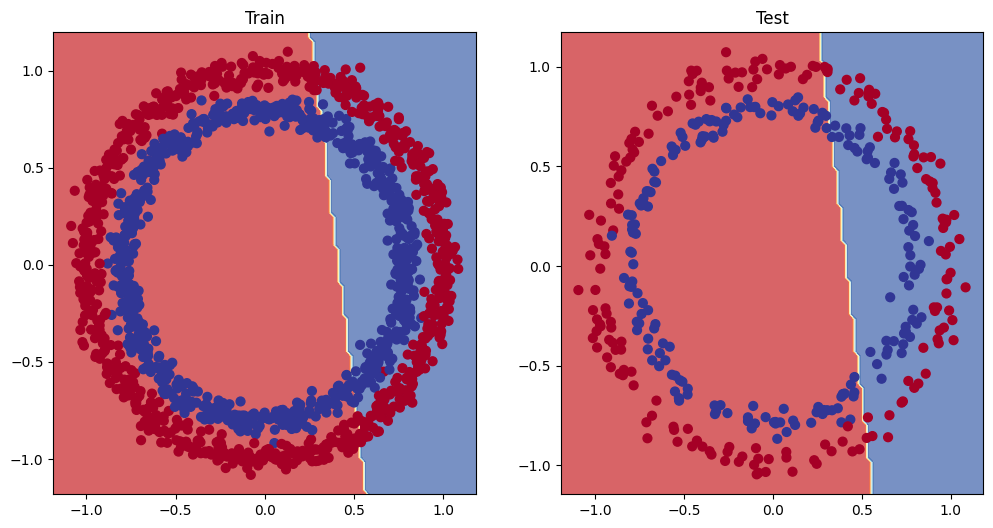

In [57]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2) 
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

In [58]:
# test non linear activation functions for the data

In [66]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [67]:
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [68]:
# training loop

torch.manual_seed(42)

epochs = 250

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_1(x_train).squeeze() # y_logits - numerical value, squeeze to remove extra 1 dimension
    y_pred = torch.round(torch.sigmoid(y_logits)) # sigmoid to contain value between 0 & 1 and round if value>=5 - 1 else 0 (binary output)
    
    loss = loss_fn(y_logits,y_train)
    acc = accuracy(y_train,y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy(y_test,test_pred)
        
        if epoch%10==0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69301, Accuracy: 49.81% | Test loss: 0.69282, Test acc: 50.75%
Epoch: 10 | Loss: 0.69296, Accuracy: 49.81% | Test loss: 0.69276, Test acc: 50.75%
Epoch: 20 | Loss: 0.69290, Accuracy: 49.81% | Test loss: 0.69271, Test acc: 50.75%
Epoch: 30 | Loss: 0.69284, Accuracy: 49.88% | Test loss: 0.69265, Test acc: 50.75%
Epoch: 40 | Loss: 0.69278, Accuracy: 49.88% | Test loss: 0.69260, Test acc: 50.75%
Epoch: 50 | Loss: 0.69273, Accuracy: 49.94% | Test loss: 0.69255, Test acc: 50.75%
Epoch: 60 | Loss: 0.69268, Accuracy: 50.19% | Test loss: 0.69250, Test acc: 50.75%
Epoch: 70 | Loss: 0.69263, Accuracy: 50.38% | Test loss: 0.69246, Test acc: 51.25%
Epoch: 80 | Loss: 0.69259, Accuracy: 50.63% | Test loss: 0.69242, Test acc: 51.25%
Epoch: 90 | Loss: 0.69255, Accuracy: 51.56% | Test loss: 0.69238, Test acc: 51.75%
Epoch: 100 | Loss: 0.69251, Accuracy: 52.94% | Test loss: 0.69234, Test acc: 52.25%
Epoch: 110 | Loss: 0.69247, Accuracy: 54.25% | Test loss: 0.69231, Test acc: 53.25%
Epo

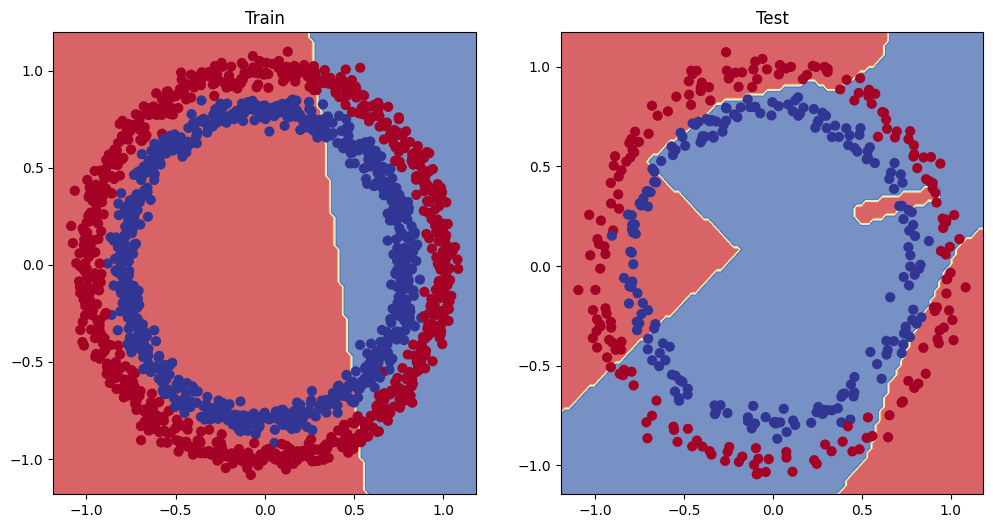

In [69]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, x_test, y_test) # model_3 = has non-linearity